## Initializations

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import ast

#for efficiently storing and manipulating multi-dimensional arrays.
import zarr
print("zarr", zarr.__version__)

# manage parallel access to the big dataset.
import dask.array as da 

def mongo_db_crops_get(dataset_id, crops_type):
    
    file_name = f'{crops_type}_crops.txt'
    
    l=[]
    with open(mongo_db_path + file_name, 'r') as f:
        if crops_type=='training':
            for line in f:
                l.append(dict(ast.literal_eval(line)))
        else:
            l=ast.literal_eval(f.read())
    
    return [item for item in l if item['dataset_id']==dataset_id]


# n5 - an open-source file format and library for efficient storage and retrieval of multi-dimensional arrays.
n5_path = '/sise/assafzar-group/assafzar/OpenOrganelle/janelia-cosem-publications/heinrich-2021a/jrc_hela-2/jrc_hela-2.n5'

mongo_db_path = '../../MongoDB/'

# access the root of the n5 container
groups = zarr.open(zarr.N5FSStore(n5_path, anon=True)) 

zarr 2.12.0


## Raw data

In [14]:

# s0 is the the full-resolution data for this particular volume
zdata = groups['volumes/raw/s0']
attrs = zdata.attrs

In [15]:
ddata = da.from_array(zdata, chunks=zdata.chunks)
ddata

,Array,Chunk
Bytes,113.87 GiB,256.00 kiB
Shape,"(6368, 1600, 12000)","(64, 64, 64)"
Count,470001 Tasks,470000 Chunks
Type,uint8,numpy.ndarray


In [16]:
for k in attrs:
    print(f"{k}:  {attrs[k]}")

name:  volumes/raw
transform:  {'axes': ['z', 'y', 'x'], 'scale': [5.24, 4.0, 4.0], 'translate': [0.0, 0.0, 0.0], 'units': ['nm', 'nm', 'nm']}


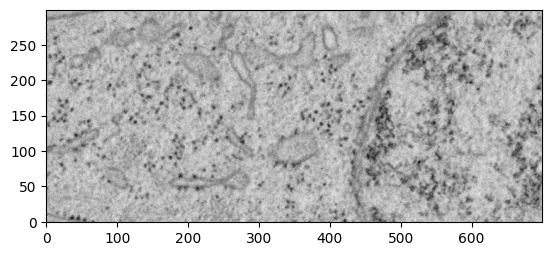

In [121]:
z = ddata.shape[0]//2
y = slice(600, 900)
x = slice(3000, 3700)
img = np.array(ddata[z,y,x])

plt.imshow(img, cmap='gray', origin='lower');

## Mongo DB Crops

In [20]:
crops = mongo_db_crops_get('jrc_hela-2', 'training')
print("crops:", len(crops))

# loof for crop #1
for c in crops:
    if c['number']=='1':
        break
c

crops: 24


{'number': '1',
 'dimensions': {'x': 500, 'y': 500, 'z': 100},
 'labels': {'present_annotated': [[1, 'ECS'],
   [2, 'Plasma membrane'],
   [3, 'Mito membrane'],
   [4, 'Mito lumen'],
   [8, 'Vesicle membrane'],
   [9, 'Vesicle lumen'],
   [10, 'MVB membrane'],
   [11, 'MVB lumen'],
   [16, 'ER membrane'],
   [17, 'ER lumen'],
   [18, 'ERES membrane'],
   [19, 'ERES lumen'],
   [30, 'Microtubules out'],
   [35, 'Cytosol'],
   [36, 'Microtubules in']],
  'present_unannotated': [[34, 'Ribosomes']],
  'absent_annotated': [[5, 'Mito DNA'],
   [6, 'Golgi Membrane'],
   [7, 'Golgi lumen'],
   [12, 'Lysosome membrane'],
   [13, 'Lysosome lumen'],
   [14, 'LD membrane'],
   [15, 'LD lumen'],
   [20, 'NE membrane'],
   [21, 'NE lumen'],
   [22, 'Nuclear pore out'],
   [23, 'Nuclear pore in'],
   [24, 'Hchrom'],
   [25, 'NHChrom'],
   [26, 'EChrom'],
   [27, 'NEChrom'],
   [28, 'Nucleoplasm'],
   [29, 'Nucleolus'],
   [31, 'Centrosome'],
   [32, 'Distal appendages'],
   [33, 'Subdistal appendages

## Ground truth

In [21]:
zgt = groups['volumes/groundtruth/0003/crop1/labels/all']
gt_attrs = zgt.attrs
for k in gt_attrs:
    print(f"{k}:  {gt_attrs[k]}")

name:  Crop1
offset:  [25864.0, 900.0, 2400.0]
offset_unit:  nm
resolution:  [2.0, 2.0, 2.0]
resolution_unit:  nm
type:  training


In [34]:
dgt = da.from_array(zgt, chunks=zgt.chunks)
dgt

dask.array<array, shape=(200, 1000, 1000), dtype=uint64, chunksize=(128, 128, 128), chunktype=numpy.ndarray>

In [35]:
dgt.shape

(200, 1000, 1000)

In [79]:
np.where(np.array(dgt[100]))

(array([  0,   0,   0, ..., 999, 999, 999]),
 array([  0,   1,   2, ..., 997, 998, 999]))

[ 1  2  3  4  8  9 10 11 16 17 18 19 30 35 36]
100 slice(0, 1000, None) slice(0, 1000, None)


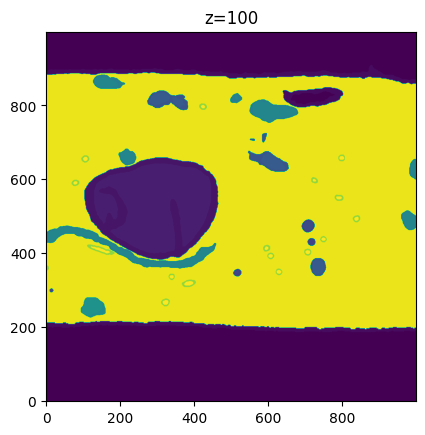

In [61]:
z_gt = dgt.shape[0]//2
y_gt = slice(0, 1000)
x_gt = slice(0, 1000)
img = np.array(dgt[z_gt,y_gt,x_gt])

print(np.unique(img))
plt.imshow(img, origin='lower');plt.title(f"z={z_gt}");
print(z_gt,y_gt,x_gt)

## Find the raw data related to the gt image

**below sections are still not OK**

In [27]:
#The crop's offset is in nm (xyz)
gt_attrs['offset']

[25864.0, 900.0, 2400.0]

In [63]:
# Transfer to the raw image scale
print(attrs['transform']['scale']) #zyx

# it seems like the translation is [4,4,4] and not [5.24, 4, 4]
scaled_offset = [int((a/b)) for (a,b) in zip(gt_attrs['offset'][::-1], [4,4,4] )]#attrs['transform']['scale'])]
scaled_offset



#, gt_attrs['resolution']

[5.24, 4.0, 4.0]


[600, 225, 6466]

In [52]:
ddata.shape

(6368, 1600, 12000)

In [64]:
z_offset, y_offset, x_offset  = scaled_offset
z_raw = z_offset + z_gt//(gt_attrs['resolution'][0])
y_raw = slice( y_offset + y_gt.start / gt_attrs['resolution'][1], y_offset + y_gt.stop / gt_attrs['resolution'][1])
x_raw = slice( x_offset + x_gt.start / gt_attrs['resolution'][2], x_offset + x_gt.stop / gt_attrs['resolution'][2])
z_raw, y_raw, x_raw 


(650.0, slice(225.0, 725.0, None), slice(6466.0, 6966.0, None))

(500, 500)


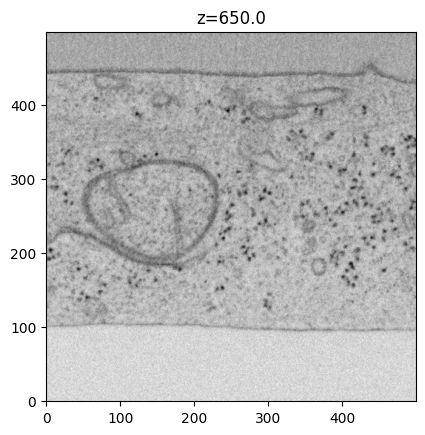

In [65]:
img = np.array(ddata[z_raw, y_raw, x_raw])
print(img.shape)
plt.imshow(img, cmap='gray', origin='lower');plt.title(f"z={z_raw}");